In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import nbodykit.lab
from nbodykit.lab import *
from nbodykit import style, setup_logging

import numpy as np
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

import sys, pickle, time, os

# nbodykit tool to read custom (non-standard) catalogue file type
from nbodykit.io.base import FileType
# nbodykit tool to creae custom subclass od CatalogSource
from nbodykit.source.catalog.file import FileCatalogFactory
# nbodykit cosmology parameters initialization
from nbodykit.lab import cosmology
from readfof import FoF_catalog
from torch import flatten, from_numpy

In [3]:
setup_logging()

In [4]:
order_folders = {
    'fiducial'  : 0,
    'h_m'       : 1,
    'h_p'       : 2,
    'Mnu_p'     : 3,
    'Mnu_pp'    : 4,
    'Mnu_ppp'   : 5,
    'ns_m'      : 6,
    'ns_p'      : 7,
    'Ob2_m'     : 8,
    'Ob2_p'     : 9,
    'Om_m'      : 10,
    'Om_p'      : 11,
    's8_m'      : 12,
    's8_p'      : 13,
    'w_m'       : 14,
    'w_p'       : 15,
    'zeldovich' : 16
}

cosmological_pars = {
    'Om'  : 0,
    'Ob'  : 1,
    'h'   : 2,
    'ns'  : 3,
    's8'  : 4,
    'w'   : 5,
    'Mnu' : 6
}

order_dimension = {
    'Om'  : 0,
    'Ob'  : 1,
    'Ob2' : 1,
    'h'   : 2,
    'ns'  : 3,
    's8'  : 4,
    'w'   : 5,
    'Mnu' : 6
}

boolean = {
    'True' : 1,
    'TRUE' : 1,
    'true' : 1,
    'False' : 0,
    'FALSE' : 0,
    'false' : 0
 }

COSMOPAR = {
#                   | Om   | Ob   |   h   |  n_s  | s_8 | Mnu | w |

    'fiducial' :    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'zeldovich':    [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Mnu_p' :       [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.1, -1],
    'Mnu_pp' :      [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.2, -1],
    'Mnu_ppp' :     [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0.4, -1],
    
    'h_m' :         [0.3175, 0.049, 0.6511, 0.9624, 0.834, 0, -1],
    'h_p' :         [0.3175, 0.049, 0.6911, 0.9624, 0.834, 0, -1],
    
    'ns_m' :        [0.3175, 0.049, 0.6711, 0.9424, 0.834, 0, -1],
    'ns_p' :        [0.3175, 0.049, 0.6711, 0.9824, 0.834, 0, -1],
    
    'Ob_m' :        [0.3175, 0.048, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob_p' :        [0.3175, 0.050, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_m' :       [0.3175, 0.047, 0.6711, 0.9624, 0.834, 0, -1],
    'Ob2_p' :       [0.3175, 0.051, 0.6711, 0.9624, 0.834, 0, -1],
    
    'Om_m' :        [0.3075, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    'Om_p' :        [0.3275, 0.049, 0.6711, 0.9624, 0.834, 0, -1],
    
    's8_m' :        [0.3175, 0.049, 0.6711, 0.9624, 0.819, 0, -1],
    's8_p' :        [0.3175, 0.049, 0.6711, 0.9624, 0.849, 0, -1],
    
    'w_m' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -0.95],
    'w_p' :         [0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1.05]
}
"""
Dictionary to assegnate to a cosmology its parameters
Ordered pairing cosmologies and the first one in with _m, the second one _p
"""

VarCosmoPar = {
    'd_h'  : 0.02,
    'd_ns' : 0.02,
    'd_Ob' : 0.001,
    'd_Ob2': 0.002,
    'd_Om' : 0.01,
    'd_s8' : 0.015,
    'd_w'  : -0.05
}
"""Values of deviations from fiducial cosmological parameters.
"""

fiducial_vals = {
    'Ob'  : 0.3175,
    'Ob2' : 0.3175,
    'Om'  : 0.049,
    'h'   : 0.6711,
    'n_s' : 0.9624,
    'ns'  : 0.9624,
    's_8' : 0.834,
    's8'  : 0.834,
    'Mnu' : 0,
    'w'   : -1
}
"""Values of fiducial cosmological parameters.
"""

'Values of fiducial cosmological parameters.\n'

In [5]:
def info_name(name):
    """Obtain realization information from namefile"""
    # assert type(name) == str
    print("TYPE: ", type(name))
    # info = name.split('_')
    info = name.split('_')[-3:]
    print("TYPE: ", info, "\n", type(info))
    info[2] = info[2].replace(".wst", "")
    N_hgrid = info[0]
    N_WSTgrid = info[1]
    n_realiz = info[2].replace(".wst", "")
    
    return [int(N_hgrid), int(N_WSTgrid), int(n_realiz)]

def cosmo_parser(name):
    """Obtain cosmology from .wst file"""
    info = name.split('_')
    if info[0] == "fiducial":
        return info[0]
    elif info[0] == "zeldovich":
        return info[0]
    else:
        return info[0] + "_" + info[1]

In [6]:
def PacMan(x, d = np.array((0, 0, 1000)) ):
   """Returns a number x in the interval [0; d]"""
   if 0 <= x[2] <= d[2]:
      return x
   elif x[2] > d[2]:
      return PacMan(x - d)
   elif x[2] < 0:
      return PacMan(x + d) 

In [7]:
def PowerSpec_Real(dens, hlength, filename):
   filename = filename.replace(".wst", ".pk")
   name = '/home/riccardo/Pk-files/'+filename
   Pk = PKL.Pk(dens, hlength, axis=0, MAS = 'CIC', verbose=False)
   with open(name.replace("_Pk_", "_k3D_"), 'ab') as file:
      pickle.dump(Pk.k3D, file)
   with open(name.replace("_Pk_", "_Nmodes3D_"), 'ab') as file:
      pickle.dump(Pk.Nmodes3D, file)
   with open(name.replace("_Pk_", "_kpar_"), 'ab') as file:
      pickle.dump(Pk.kpar, file)
   with open(name.replace("_Pk_", "_kper_"), 'ab') as file:
      pickle.dump(Pk.kper, file)
   with open(name.replace("_Pk_", "_Pk_"), 'ab') as file:
      pickle.dump(Pk.Pk, file)

def PowerSpec_RSD(dens, hlength, filename):
   filename = filename.replace(".wst", ".pk")
   Pk = PKL.Pk(dens, hlength, axis=2, MAS = 'CIC', verbose=False)
   name = '/home/riccardo/Pk-files/'+filename
   with open(name.replace("_Pk_", "_k3D_"), 'ab') as file:
      pickle.dump(Pk.k3D, file)
   with open(name.replace("_Pk_", "_Nmodes3D_"), 'ab') as file:
      pickle.dump(Pk.Nmodes3D, file)
   with open(name.replace("_Pk_", "_kpar_"), 'ab') as file:
      pickle.dump(Pk.kpar, file)
   with open(name.replace("_Pk_", "_kper_"), 'ab') as file:
      pickle.dump(Pk.kper, file)
   with open(name.replace("_Pk_", "_Pk_"), 'ab') as file:
      pickle.dump(Pk.Pk, file)

In [8]:
def HaloWST_one_f_MASL(filename, snapdir, i, snapnum=2, N_grid=256, hlength=1000, j=4, l=4):
   """Funcion that evaluates Scattering Transform coefficients of first and second order,
   using a halo database from Quijote simulations.
   NB: this function uses `MAS_library.MA()` to generate density matrix, not `myCIC`.

   Arguments:
   - `filename`: name of the file conaining WST coefficients of first and second order
   - `snapdir` : the tree to the directory containing the datas, STOP before '/groups_';
   - `snapnum` : indicates the choosen redshift (def: 2)
   - `N_hgrid` : number of cells to divide the halos catalogue (def: 256)
   - `hlength` : dimension of the cubic simulation (def: 1000 Mpc/h)
   - `N_WSTgrid` : number of cells to divide the density field, generated by myCIC,
      to calculate WST coefficients (def: 256)
   - `j` : coefficient for scattering transform evaluation (def: 4)
   - `l` : coefficient for scattering transform evaluation (def: 4)
   - `i` : oprional, svariable for print execution time, takes value from iterable object of for loop

   Returns:
   - prints fist and second order scattering coefficients into a single files as 1D array.
   """
   
   z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
   redshift = z_dict[snapnum]
   strt = time.time()
   H_0 = 100 * COSMOPAR[cosmo_parser(filename)][2]

   print(i," - Reading datas", flush = True) 
   datas = FoF_catalog(snapdir, snapnum, read_IDs=False)
   print("  Data file readed -> variables assignement", flush = True)
   
   # ======== Reading datas ==========================================================================================
   pos_h = (datas.GroupPos/1e3).astype(np.float32)                     # positions in Mpc/h
   mass = (datas.GroupMass * 1e10).astype(np.float32)                  # masses in M_sun/
   vel = (datas.GroupVel*(1.0+redshift)).astype(np.float32)            # Halo peculiar velocities in km/s
   del datas

   # if len(mass_M) > 0:
   START = time.time()
   dens = np.zeros((N_grid, N_grid, N_grid), dtype=np.float32)
   MASL.MA(pos_h, dens, hlength, 'CIC', W = mass)
   dens /= np.mean(dens, dtype=np.float32)
   dens -= 1.0
   # WST eval
   # Sx = S.scattering(from_numpy(dens))
   # with open('/home/riccardo/WST-files/'+filename.replace("_coefficients_", "_coefficients_M_Ns_"), 'ab') as file:
   #    pickle.dump(flatten(Sx, start_dim=0).cpu().detach().numpy(), file)

   # Pk eval
   PowerSpec_Real(dens, hlength, filename.replace("_coefficients_", "_Pk_M_Ns_"))
   PowerSpec_RSD(dens, hlength, filename.replace("_coefficients_", "_Pk_M_RDs_"))

   print("  completed M_Ns in: ", round((time.time()-START)/60, 3), " min", flush = True)

   del dens#, Sx

   START = time.time()
   dens = np.zeros((N_grid, N_grid, N_grid), dtype=np.float32)
   for i in range(len(vel)):
      pos_h[i] = PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/H_0]) ) )
   MASL.MA(pos_h, dens, hlength, 'CIC', W = mass)
   dens /= np.mean(dens, dtype=np.float32)
   dens -= 1.0
   # WST eval
   # Sx = S.scattering(from_numpy(dens))   
   # with open('/home/riccardo/WST-files/'+filename.replace("_coefficients_", "_coefficients_M_RDs_"), 'ab') as file:
   #    pickle.dump(flatten(Sx, start_dim=0).cpu().detach().numpy(), file)
   # PowerSpec_RSD(dens, hlength, filename.replace("_coefficients_", "_Pk_M_RDs_"))
   print("  completed M_Rs in: ", round((time.time()-START)/60, 3), " min", flush = True)

   print("  The files' been written\n    TIME LAP: ", round((time.time()-strt)/60, 3), " mins\n", flush = True)

In [9]:
def CALCULUS(S, N_grid = 256, n_realiz = -1, Ff = 'fiducial', root='/workplace/riccardo/Halos/', sig = "s08", qu = "q08"):
   """Evaluates WST coefficients and print them in one/two files (this is an option) for given folders
   using `HaloWST_one_f_MASL`
   """

   if n_realiz > 0:
      num = n_realiz
      in_realizations = os.listdir(root+Ff)[0:num]
   elif n_realiz < 0:
      in_realizations = os.listdir(root+Ff)
      num = len(in_realizations)
   else:
      assert False, "No realization to analize!"
    
   filename = Ff+'_coefficients_' +sig + '_' + qu + '_' +str(N_grid)+"_"+str(num)+'.wst'

   # delete existing file, want a new one (not extending it)
   if not os.path.exists('/home/riccardo/WST-files/'+filename):
      # os.remove('/home/riccardo/WST-files/'+filename)
      for i in range(len(in_realizations)):
         snapdir = root + Ff + '/' + in_realizations[i]
         HaloWST_one_f_MASL(filename = filename, snapdir = snapdir, N_grid = N_grid, i=i)
   else:
      print("WARNING: ", filename, "already exists")

In [81]:
N_grid = 256
hlength = 1000

snapnum = 2
filename = "fiducial"+'_coefficients_' +"08" + '_' + "08" + '_' +str(N_grid)+"_"+str(1000)+'.wst'
snapdir = "/media/fuffolo97/HDD1/UNI/Tesi/halos/" + cosmo_parser(filename) + "/0"

z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
redshift = z_dict[snapnum]
strt = time.time()
H_0 = 100 * COSMOPAR["fiducial"][2]

datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
pos_h = (datas.GroupPos/1e3).astype(np.float32)                     # positions in Mpc/h
mass = (datas.GroupMass * 1e10).astype(np.float32)                  # masses in M_sun/
vel = (datas.GroupVel*(1.0+redshift)).astype(np.float32)            # Halo peculiar velocities in km/s

In [71]:
type(pos_h)

numpy.ndarray

In [14]:
assert len(pos_h) == len(mass) == len(vel)
assert np.shape(vel) == np.shape(pos_h)

In [17]:
# class QuijFile(FileType):
#     """A file-like object to read .0 Quijote catalog"""
#     def __init__(self, path):
#         self.path = path
#         self.attrs = {}
#         # load the data and set size and dtype
#         self._data = np.load(self.path)
#         self.size = len(self._data) # total size
#         self.dtype = self._data.Float32 # data dtype
#         self.redshift = 1
#         self.snapdir = path.replace("/groups_002/group_tab_002.0", "")

#     def read(self):
#         return FoF_catalog(self.path, self.redshift, read_IDs=False)
    
# QuijCatalog = FileCatalogFactory('QuijCatalog', QuijFile)

# f = QuijCatalog("/media/fuffolo97/HDD1/UNI/Tesi/halos/fiducial/0/groups_002/group_tab_002.0")

# # ----- OUTPUT -----------------------
# # ValueError                                Traceback (most recent call last)
# # ValueError: Cannot load file containing pickled data when allow_pickle=False
# #  

## N-BodyKit

In [18]:
cosmo_nbk = cosmology.Cosmology(h=fiducial_vals["h"],
                                sigma8=fiducial_vals["s8"],
                                #Omega0_b=fiducial_vals["Ob"],
                                Omega0_cdm = fiducial_vals["Om"],
                                n_s=fiducial_vals["ns"],
                                # m_ncdm=fiducial_vals["Mnu"]
                                )

BoxSize = 1000.
line_of_sight = [0, 0, 1]

In [19]:
# data_nbk = np.empty(len(mass), dtype=[('Position', ('f8', 3)), ('RSDPosition', ('f8', 3)),('Velocity', ('f8', 3)), ('Mass', 'f8')])
# # data_nbk = np.empty(len(mass), dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
# data_nbk["Position"] = pos_h
# data_nbk["Velocity"] = vel
# data_nbk["Mass"] = mass
# data_nbk['RSDPosition'] = data_nbk['Position'] + data_nbk['Velocity'] * line_of_sight
# np.save("./npy-example.npy", data_nbk)

(195524, 3)

In [20]:
A = np.empty(len(pos_h), dtype=[('Position', ('f8', 3)), ('Mass', ('f8'))])
print(np.shape(A["Position"]))

(195524, 3)


In [21]:
data_nbk = np.empty(len(mass), dtype=[('Position', ('f8', 3)), ('Mass', ('f8'))])
# data_nbk = np.empty(len(mass), dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
print(np.shape(data_nbk["Position"]))
data_nbk["Position"][:] = pos_h[:]
data_nbk["Mass"][:] = mass[:]
np.save("./npy-example.npy", data_nbk)

(195524, 3)


In [22]:
class QuijFile(FileType):
    """A file-like object to read 'xxx.0' Quijote catalog"""
    def __init__(self, path, Nmesh=256):
        self.path = path
        self.attrs = {}
        # load the data and set size and dtype
        self._data = np.load(self.path)
        self.size  = len(self._data)  # total size
        self.dtype = self._data.dtype # data dtype

    def read(self, columns, start, stop, step=1):
        return self._data[start:stop:step]
    
QuijCatalog = FileCatalogFactory('QuijCatalog', QuijFile)

In [23]:
np.shape(pos_h)

(195524, 3)

### from demo

redshift_a = 0.55
cosmo_a = cosmology.Planck15
Plin_a = cosmology.LinearPower(cosmo_a, redshift, transfer='EisensteinHu')
b1 = 2.0

cat = LogNormalCatalog(Plin=Plin_a, nbar=3e-4, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

In [24]:
f = QuijCatalog("npy-example.npy")
mesh = f.to_mesh(resampler='cic', Nmesh=256, compensated=True, position='Position', weight="Mass", BoxSize=BoxSize)
# mesh = c.to_mesh(resampler='cic', Nmesh=256, compensated=True, position='RSDPosition')

[ 000031.22 ]   0: 09-27 11:26  CatalogSource   INFO     Extra arguments to FileType: () {}


In [28]:
r_3d_bis = ConvolvedFFTPower(mesh, poles=[0, 2], dk=0.01, kmin=0.001)

TypeError: input sources should be a FKPCatalog or FKPCatalogMesh

In [23]:
r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
P3D = r_3d.power

[ 000019.76 ]   0: 09-26 17:20  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 195524 


ValueError: error trying to view slice as a single numpy array: cannot reshape array of size 4 into shape (3)

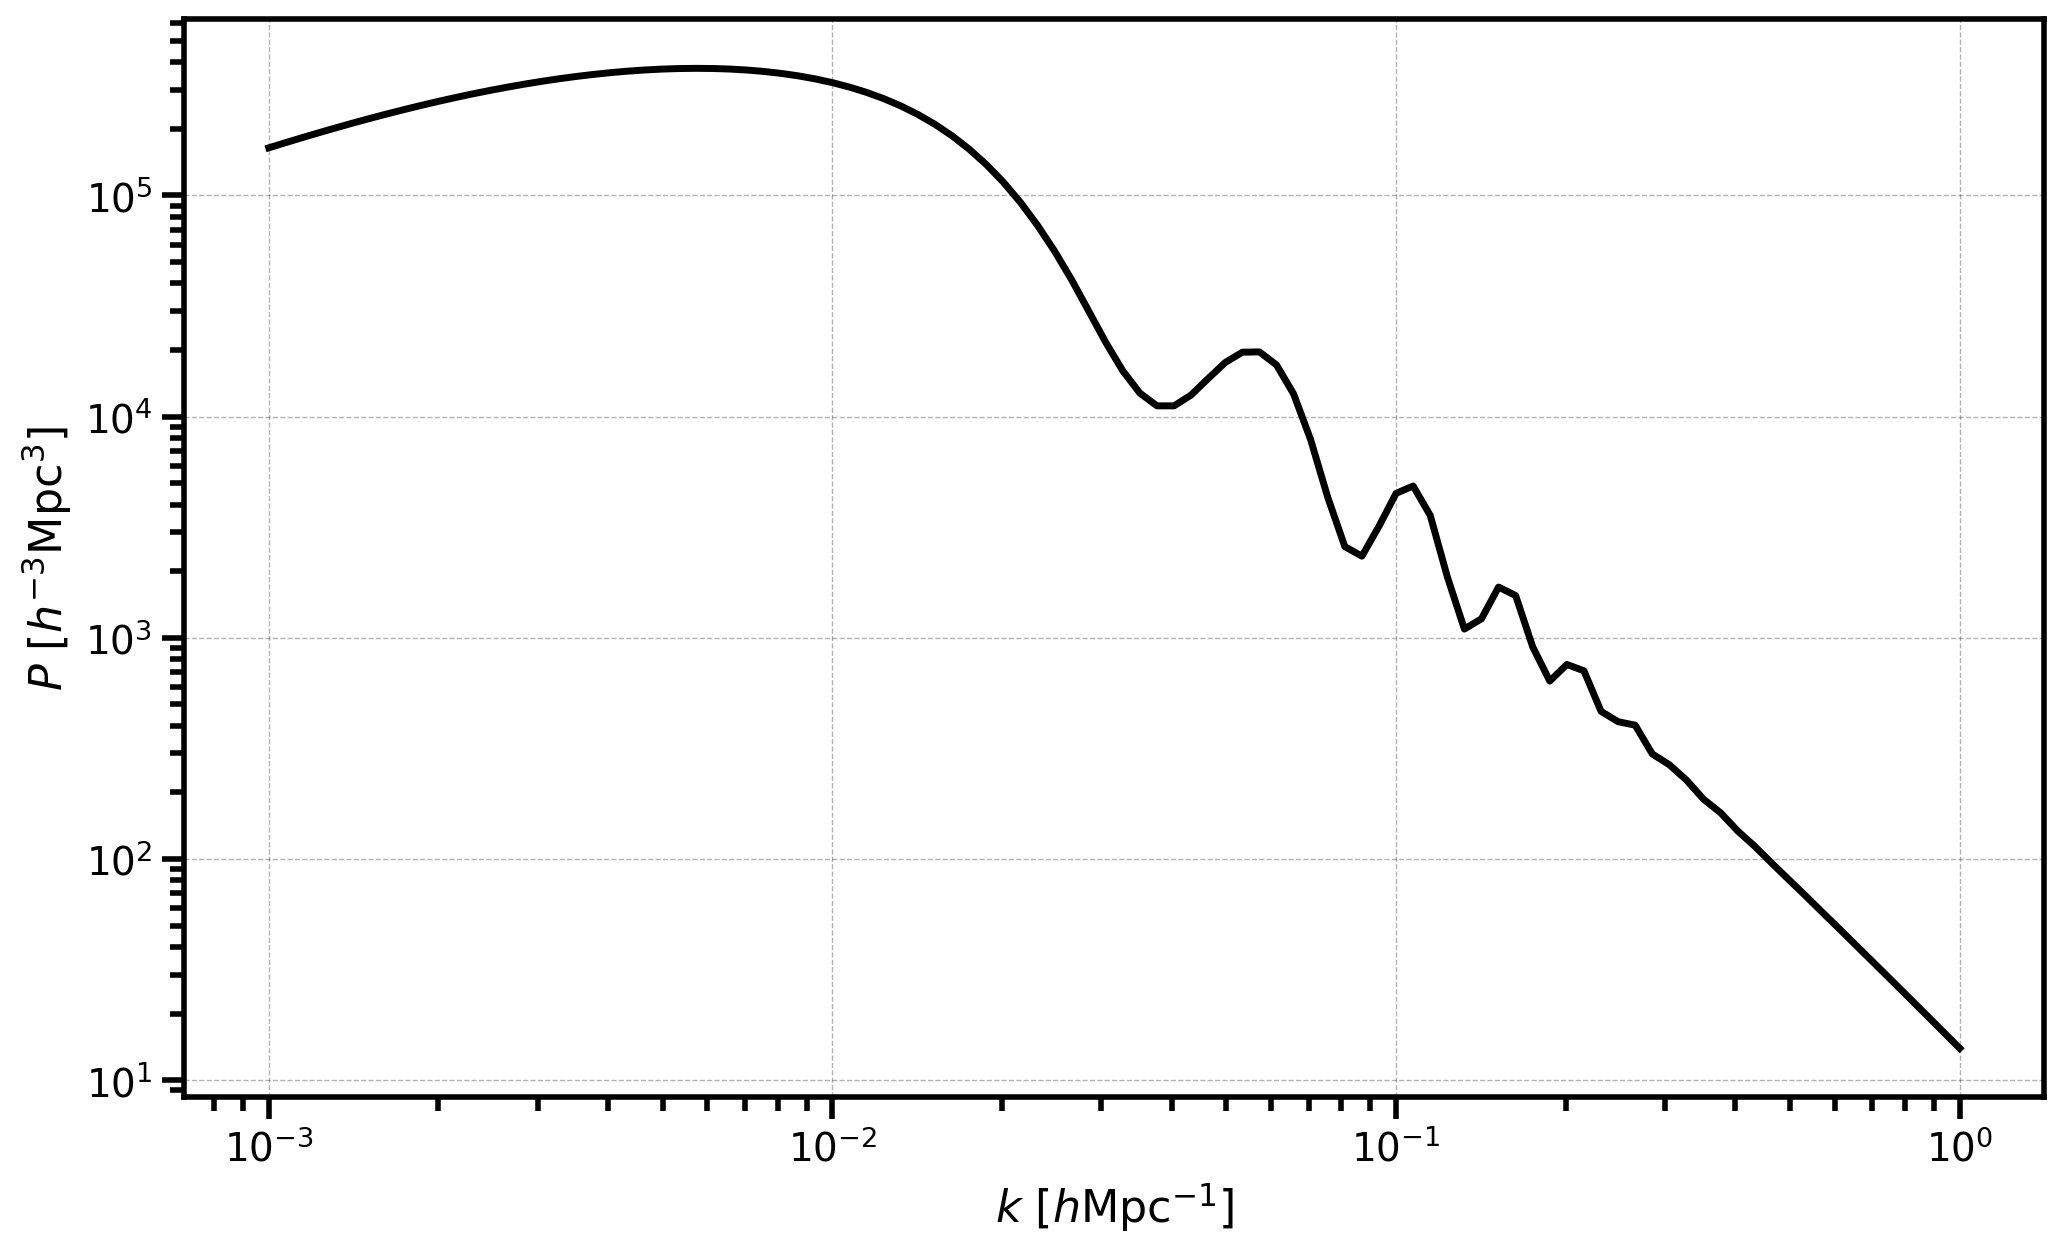

In [ ]:
Plin = cosmology.LinearPower(cosmo_nbk, redshift=1)
k = np.logspace(-3, 0, 100)
plt.loglog(k, Plin(k), c='k')

plt.xlabel(r"$k$ $[h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P$ $[h^{-3} \mathrm{Mpc}^{3}]$")
plt.show()

(0.01, 0.6)

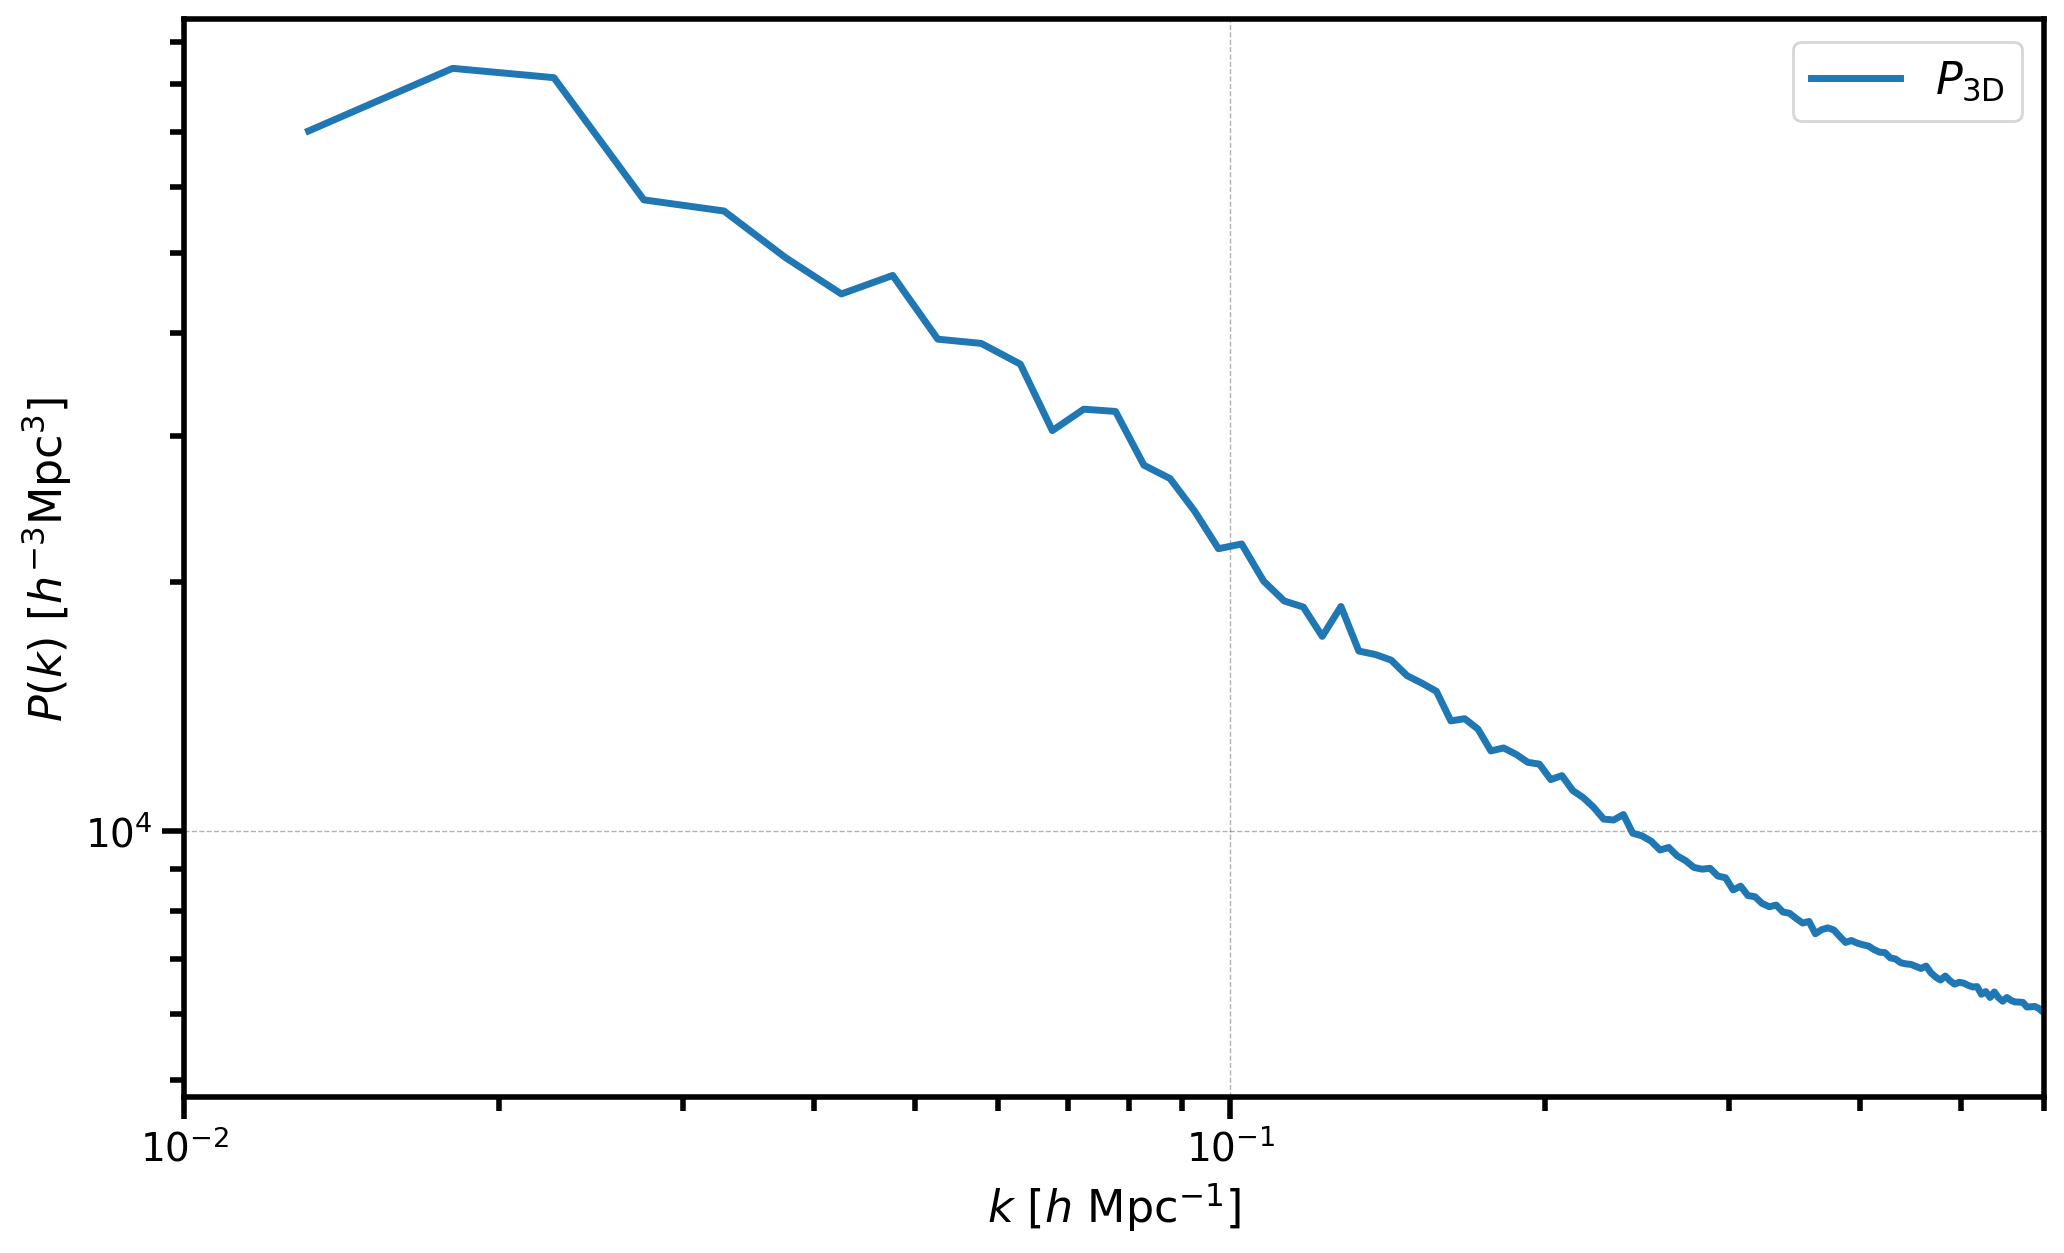

In [ ]:
plt.loglog(P3D['k'], P3D['power'].real, label=r"$P_\mathrm{3D}$")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

In [ ]:
data = numpy.empty(1024, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
np.shape(data)

(1024,)

In [ ]:
np.shape(data_nbk)

(195524,)

In [ ]:
data_nbk[0]

([609.89459229, 643.9901123 , 503.4715271 ], 1.26650895e+15)

In [ ]:
data[0]

([6.92131761e-310, 6.92131761e-310, 1.02544384e-315], 1.02544384e-315)

In [29]:
pos_h[0]

array([609.8946 , 643.9901 , 503.47153], dtype=float32)

In [30]:
dtype_AA = [("Position", ("f8", 3)), ("Mass", "f8")]
data_AA = np.array(list(zip(pos_h, mass)), dtype=dtype_AA)

In [32]:
np.shape(data_AA)

(195524,)

In [60]:
x = np.array([1.0, 2.0, 3.0, 4.0])
y = np.array([2.0, 3.0, 4.0, 5.0])
z = np.array([3.0, 4.0, 5.0, 6.0])
redshift_B = np.array([0.1, 0.2, 0.3, 0.4])

dtype_B = [('Position', ('f8', 3)), ('Redshift', 'f8')]
dtype_BB = [('Position', ('f8', 3)), ('Redshift', 'f8')]

In [61]:
data_B = np.column_stack((x, y, z, redshift_B))
data_BB = np.column_stack((x, y, z))

In [68]:
np.shape(data_BB)

(4, 3)

In [62]:
custom_catalog = np.array(data_B, dtype=dtype_B)
custom_catalog_B = np.array(data_BB, dtype=dtype_BB)

In [63]:
from nbodykit.source.catalog import ArrayCatalog

In [64]:
custom_catalog = ArrayCatalog(custom_catalog)
custom_catalog_B = ArrayCatalog(custom_catalog_B)

In [65]:
mesh_B = custom_catalog.to_mesh(resampler='cic', Nmesh=256, compensated=True, position='Position', weight="Redshift", BoxSize=BoxSize)
mesh_BB = custom_catalog_B.to_mesh(resampler='cic', Nmesh=256, compensated=True, position='Position', weight="Redshift", BoxSize=BoxSize)

In [66]:
r_3d = FFTPower(custom_catalog_B, BoxSize=10, Nmesh=256, mode='1d', dk=0.005, kmin=0.01)

[ 001651.43 ]   0: 09-27 11:53  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 4 


ValueError: could not broadcast input array from shape (4,3) into shape (4,)

In [59]:
r_3d = FFTPower(custom_catalog, BoxSize=10, Nmesh=256, mode='1d', dk=0.005, kmin=0.01)

[ 001450.62 ]   0: 09-27 11:50  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 4 


ValueError: could not broadcast input array from shape (4,3) into shape (4,)

In [73]:
snapdir

'/media/fuffolo97/HDD1/UNI/Tesi/halos/fiducial/0'

In [74]:
from nbodykit.source.catalog import BinaryCatalog

In [78]:
with open('./data_sounrce_try.dat', "wb") as ff:
    pos_h.tofile(ff); vel.tofile(ff); mass.tofile(ff)

f = BinaryCatalog(ff.name, [("Position", (np.float32, 3)), ("Velocity", (np.float32, 3)), ("Mass", np.float32)])

[ 010985.97 ]   0: 09-27 14:29  CatalogSource   INFO     Extra arguments to FileType: ([('Position', (<class 'numpy.float32'>, 3)), ('Velocity', (<class 'numpy.float32'>, 3)), ('Mass', <class 'numpy.float32'>)],) {}


In [79]:
mesh = f_C.to_mesh(resampler='cic', Nmesh=256, compensated=True, position='Position', weight="Mass", BoxSize=BoxSize)

In [80]:
r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)

[ 011025.55 ]   0: 09-27 14:29  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 195524 
[ 011025.76 ]   0: 09-27 14:29  CatalogMesh     INFO     painted 195524 out of 195524 objects to mesh
[ 011025.77 ]   0: 09-27 14:29  CatalogMesh     INFO     painted 195524 out of 195524 objects to mesh
[ 011025.77 ]   0: 09-27 14:29  CatalogMesh     INFO     mean particles per cell is 3.54574e+11
[ 011025.77 ]   0: 09-27 14:29  CatalogMesh     INFO     sum is 5.94877e+18 
[ 011025.78 ]   0: 09-27 14:29  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 011026.06 ]   0: 09-27 14:29  CatalogMesh     INFO     field: (BinaryCatalog(size=195524, FileStack(BinaryFile(path=/home/fuffolo97/TESI/data_sounrce_try.dat, dataset=*, ncolumns=3, shape=(195524,)>, ... 1 files)) as CatalogMesh) painting done
